In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pd_reader
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math
import os 
from tqdm import tqdm 

%matplotlib inline

In [4]:
## Feed Data into backtrader
# ticker1 = 'AAL'
# aal = pd.read_csv(f".\\bt_stock_data\{ticker1}.csv", index_col=0, parse_dates=True)
# aal_feed = bt.feeds.PandasData(dataname=aal, openinterest=-1)

In [5]:
## Startegy
initial_cap = 100000
class BuyAndHoldStrategy(bt.Strategy):
    
    def __init__(self):
        self.pending_orders = dict()
        
    def notify_order(self, order):
        if not order is None:
            if order.status == order.Completed:
                symbol = self.pending_orders[order.ref]
                print('%s: %s order filled' % (self.datetime.date(), symbol))
            
    #! this line of code is part of solution described above
    def prenext(self):
        self.next()
    
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        for i, d in enumerate(self.datas):
            #! this line of code is part of solution described above
            #! check if instrument is available for trading

            can_trade =  self.datetime.date() in self.datas[i]._dataname.index 
            no_position = not self.getposition(self.datas[i])

            if can_trade:
                ta = self.datas[i]._dataname['transactionAmounts'].loc[self.datetime.date()]
                tn = self.datas[i]._dataname['numTransactions'].loc[self.datetime.date()]
                if ~np.isnan(ta) and ~np.isnan(tn) and ~np.isinf(ta) and ~np.isinf(tn):
                    if (tn > 2):
                        volume = self.datas[i]._dataname['volume'].loc[self.datetime.date()]
                        prc = self.datas[i]._dataname['close'].loc[self.datetime.date()]
                        # we want to allocate $20000 in each instrument, but as order will
                        # be executed only at the next days's open price, we leave a margin of $1000
                        # to make sure that order will not be cancelled due to lack of cash
                        order = self.order_target_value(data=self.datas[i], target= - np.sign(ta) * min(tn * np.abs(ta)/500, 10000))
                        print(i, ta)
                        if not order is None:
                            self.pending_orders[order.ref] = d._name

                    print('%s: %s order submitted' % (self.datetime.date(), d._name))      


In [6]:
df0 = pd.read_csv(f"./bt_stock_data/AAL.csv", index_col=0)
bad_tickers = []
for file in tqdm(os.listdir("./bt_stock_data/")):
       df = pd.read_csv(f"./bt_stock_data/{file}", index_col=0)
       if len(df.index) != len(df0.index):
              bad_tickers.append(file[:-4])

100%|██████████| 469/469 [00:02<00:00, 225.81it/s]


In [7]:
## Initialize backtesting   
cerebro = bt.Cerebro(stdstats=False)
cnt = 0
for file in tqdm(os.listdir("./bt_stock_data/")):
    ticker = file[:-4]
    df_feed = pd.read_csv(f".\\bt_stock_data\{ticker}.csv", index_col=0, parse_dates=True)
    if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
        if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
            continue
        if ticker in bad_tickers:
            continue
        cerebro.adddata(bt.feeds.PandasData(dataname=df_feed, openinterest=-1), name=ticker)
        cnt += 1
print("validnum: ", cnt)
cerebro.broker.setcash(10000*cnt)
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

strats = cerebro.run()
# cplots = cerebro.plot()

100%|██████████| 469/469 [00:02<00:00, 219.67it/s]


validnum:  305
2018-01-02: ABC order submitted
2018-01-02: ALGN order submitted
25 0.0
2018-01-02: APA order submitted
26 0.0
2018-01-02: APD order submitted
2018-01-02: BIIB order submitted
2018-01-02: BRO order submitted
51 0.0
2018-01-02: CHD order submitted
2018-01-02: CME order submitted
63 0.0
2018-01-02: COP order submitted
2018-01-02: DAL order submitted
104 -190127.74
2018-01-02: FDS order submitted
2018-01-02: FOX order submitted
114 0.0
2018-01-02: FTV order submitted
116 0.0
2018-01-02: GILD order submitted
119 -231683.14
2018-01-02: GOOG order submitted
2018-01-02: HPQ order submitted
2018-01-02: HSIC order submitted
2018-01-02: ILMN order submitted
2018-01-02: KR order submitted
2018-01-02: LUV order submitted
2018-01-02: MAA order submitted
2018-01-02: MNST order submitted
190 67664.66
2018-01-02: MSI order submitted
2018-01-02: MU order submitted
199 121249.86
2018-01-02: NLSN order submitted
2018-01-02: NWL order submitted
2018-01-02: OKE order submitted
214 -4682208.2

C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:299: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  '=False to disable.')
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:352: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  txn_val = txn_val.groupby('date').cumsum()
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:357: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  pd.TimeGrouper('24H'))['exposure'].transform(max))


Start date,2018-01-02
End date,2021-12-31
Total months,48
,Backtest
Annual return,-5.1%
Cumulative returns,-18.9%
Annual volatility,7.2%
Sharpe ratio,-0.69
Calmar ratio,-0.20
Stability,0.63
Max drawdown,-26.0%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.01,2020-03-23,2021-12-29,NaT,NaN
1,11.53,2018-12-24,2020-02-19,2020-03-12,319
2,3.08,2018-04-02,2018-09-20,2018-12-14,185
3,2.26,2020-03-12,2020-03-13,2020-03-16,3
4,2.07,2018-02-08,2018-03-09,2018-04-02,38


Stress Events,mean,min,max
New Normal,-0.02%,-2.68%,3.97%


Top 10 long positions of all time,max
sid,
DOV,0.69%
TDY,0.63%
MCK,0.63%
PAYX,0.62%
JBHT,0.60%
PNW,0.60%
APH,0.60%
JPM,0.59%
RMD,0.59%


Top 10 short positions of all time,max
sid,
WRK,-0.68%
ON,-0.65%
NUE,-0.64%
ORLY,-0.62%
MCK,-0.62%
EXR,-0.61%
HPQ,-0.61%
JBHT,-0.60%
TER,-0.60%


Top 10 positions of all time,max
sid,
DOV,0.69%
WRK,0.68%
ON,0.65%
NUE,0.64%
TDY,0.63%
MCK,0.63%
ORLY,0.62%
PAYX,0.62%
EXR,0.61%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:309: RuntimeWarning: divide by zero encountered in true_divide
  ending_price = ending_val / ending_amount
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\Users\Xiong\AppData\R

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,3532.00,2701.00,831.00
Percent profitable,0.40,0.34,0.61
Winning round_trips,1424.00,913.00,511.00
Losing round_trips,2108.00,1788.00,320.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-478521.71,$-591387.43,$112865.71
Gross profit,$805682.92,$558076.41,$247606.51
Gross loss,$-1284204.64,$-1149463.84,$-134740.80
Profit factor,$0.63,$0.49,$1.84
Avg. trade net profit,$-135.48,$-218.95,$135.82
Avg. winning trade,$565.79,$611.26,$484.55
Avg. losing trade,$-609.21,$-642.88,$-421.06
Ratio Avg. Win:Avg. Loss,$0.93,$0.95,$1.15
Largest winning trade,$8524.62,$8524.62,$6446.82
Largest losing trade,$-11406.04,$-11406.04,$-5381.01


Duration stats,All trades,Short trades,Long trades
Avg duration,102 days 15:17:44.099943,111 days 06:37:11.173639,74 days 13:25:46.571600
Median duration,58 days 00:00:00,62 days 00:00:00,43 days 00:00:00
Longest duration,1183 days 00:00:00,1183 days 00:00:00,770 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-0.00%,-0.01%,0.00%
Avg returns winning,0.01%,0.02%,0.01%
Avg returns losing,-0.02%,-0.02%,-0.01%
Median returns all round_trips,-0.00%,-0.00%,0.00%
Median returns winning,0.01%,0.01%,0.00%
Median returns losing,-0.01%,-0.01%,-0.00%
Largest winning trade,0.21%,0.21%,0.17%
Largest losing trade,-0.29%,-0.29%,-0.14%


Symbol stats,AAL,AAP,AAPL,ABBV,ABC,ACN,ADP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMD,AMGN,AMP,AMZN,ANET,AON,AOS,APA,APD,APH,APTV,ATO,ATVI,AVB,AVGO,AVY,AWK,BA,BBY,BDX,BIIB,BK,BLK,BR,BRO,BWA,CAH,CB,CCI,CCL,CDW,CE,CFG,CHD,CHTR,CI,CINF,CL,CME,CMG,CMI,CMS,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CTAS,CTLT,CTSH,CVX,DAL,DFS,DG,DHI,DHR,DISH,DOV,DRI,DTE,DUK,DVA,DVN,DXCM,EBAY,EIX,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETR,EXPD,EXR,FAST,FBHS,FCX,FDS,FDX,FE,FFIV,FITB,FMC,FOX,FOXA,FRT,FTNT,FTV,GD,GILD,GLW,GM,GOOG,GPN,GRMN,GWW,HCA,HES,HOLX,HPE,HPQ,HSIC,HST,HSY,ICE,IDXX,IEX,IFF,ILMN,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,ITW,IVZ,JBHT,JCI,JKHY,JNJ,JNPR,JPM,KHC,KLAC,KMB,KMI,KMX,KO,KR,LH,LKQ,LMT,LNC,LNT,LRCX,LUV,LW,LYB,MAA,MAR,MAS,MCHP,MCK,MDLZ,MDT,MET,MLM,MMC,MMM,MNST,MOS,MPC,MRK,MRO,MS,MSCI,MSFT,MSI,MTCH,MTD,MU,NDAQ,NDSN,NFLX,NI,NKE,NLSN,NOW,NRG,NSC,NTAP,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,ODFL,OKE,OMC,ON,ORCL,ORLY,PAYC,PAYX,PEG,PEP,PFG,PHM,PKG,PKI,PNC,PNR,PNW,POOL,PPL,PSX,PTC,PWR,PXD,QCOM,QRVO,RCL,RE,REG,REGN,RF,RJF,RMD,ROL,ROP,SCHW,SEE,SHW,SIVB,SJM,SNA,SNPS,SPG,SPGI,STE,STT,SWK,SYK,TDG,TDY,TEL,TER,TFX,TGT,TJX,TMO,TMUS,TPR,TRMB,TROW,TRV,TSLA,TSN,TWTR,TXN,UDR,UHS,ULTA,UNP,UPS,VFC,VLO,VMC,VNO,VRSK,VRSN,VRTX,WAB,WBA,WDC,WEC,WHR,WM,WMB,WRB,WRK,WST,WY,WYNN,XOM,XRAY,XYL,YUM,ZBRA,ZTS
Avg returns all round_trips,0.03%,0.00%,-0.01%,0.00%,-0.00%,-0.00%,-0.01%,0.01%,-0.01%,0.02%,-0.01%,-0.02%,-0.00%,-0.03%,-0.04%,0.01%,-0.00%,-0.01%,-0.05%,-0.01%,-0.00%,-0.03%,-0.01%,0.00%,0.02%,-0.00%,-0.00%,-0.01%,0.01%,-0.00%,0.01%,0.00%,-0.03%,-0.01%,-0.00%,0.00%,-0.00%,0.00%,0.02%,0.00%,-0.01%,-0.01%,-0.03%,0.03%,0.00%,0.00%,-0.03%,0.03%,-0.01%,0.00%,0.03%,0.00%,0.00%,0.00%,-0.02%,0.00%,-0.01%,-0.02%,0.00%,-0.00%,0.00%,0.01%,0.00%,0.01%,-0.02%,0.00%,-0.05%,-0.02%,-0.01%,-0.00%,0.01%,-0.00%,0.01%,0.01%,0.01%,-0.01%,-0.00%,-0.01%,0.01%,-0.02%,0.00%,0.01%,0.00%,-0.00%,-0.01%,-0.04%,-0.00%,0.01%,0.01%,0.00%,-0.05%,0.00%,-0.01%,-0.01%,0.00%,-0.00%,-0.02%,-0.00%,-0.00%,-0.01%,0.02%,-0.01%,0.01%,-0.02%,-0.01%,-0.01%,0.00%,-0.01%,0.01%,-0.01%,-0.00%,-0.01%,0.02%,-0.01%,-0.00%,-0.00%,0.00%,-0.00%,0.01%,-0.03%,0.00%,-0.02%,-0.00%,-0.00%,-0.02%,-0.01%,0.00%,0.02%,-0.01%,-0.01%,0.00%,-0.01%,-0.01%,-0.01%,-0.00%,-0.01%,-0.00%,-0.01%,-0.01%,0.01%,-0.00%,-0.01%,0.02%,0.00%,-0.01%,-0.00%,0.01%,-0.00%,-0.01%,-0.00%,0.00%,-0.01%,-0.01%,-0.02%,-0.01%,-0.00%,0.00%,-0.01%,0.01%,-0.01%,-0.02%,-0.01%,-0.00%,0.01%,-0.00%,-0.03%,0.01%,-0.01%,-0.00%,-0.01%,0.00%,-0.00%,-0.00%,-0.00%,-0.01%,-0.01%,0.01%,-0.00%,0.00%,0.00%,0.00%,-0.00%,0.03%,0.00%,-0.02%,-0.00%,-0.01%,0.00%,0.00%,0.01%,-0.07%,-0.03%,-0.01%,0.01%,0.00%,-0.00%,-0.01%,-0.00%,-0.01%,-0.01%,0.01%,-0.01%,-0.01%,-0.03%,-0.11%,-0.01%,-0.00%,-0.00%,-0.03%,-0.03%,0.01%,0.00%,-0.00%,-0.00%,0.00%,-0.04%,-0.02%,-0.00%,-0.01%,-0.01%,-0.00%,-0.01%,0.01%,-0.01%,-0.01%,0.00%,-0.03%,-0.02%,0.01%,-0.01%,-0.02%,0.00%,-0.01%,-0.01%,0.01%,0.00%,-0.00%,-0.01%,0.01%,-0.01%,-0.01%,0.00%,-0.03%,0.00%,0.02%,0.00%,-0.01%,0.00%,-0.00%,-0.02%,0.01%,0.00%,-0.01%,0.01%,-0.01%,-0.02%,0.00%,-0.01%,-0.00%,-0.01%,-0.01%,-0.02%,-0.01%,-0.01%,-0.02%,-0.00%,-0.00%,0.00%,0.00%,-0.06%,0.01%,-0.00%,0.00%,-0.01%,-0.01%,-0.02%,0.00%,-0.01%,0.00%,-0.01%,-0.00%,-0.02%,-0.01%,-0.00%,-0.00%,0.01%,-0.02%,0.01%,-0.00%,-0.00%,0.01%,0.01%,-0.00%,0.01%,-0.00%,0.00%,-0.00%,-0.00%,-0.01%,0.00%,0.00%,-0.01%,-0.00%
Avg returns winning,0.05%,0.01%,0.03%,0.02%,0.01%,0.00%,0.02%,0.02%,0.03%,0.04%,0.01%,nan%,0.01%,0.03%,0.00%,0.02%,0.00%,0.01%,0.01%,0.00%,0.02%,0.01%,0.01%,0.04%,0.02%,0.01%,0.00%,0.01%,0.02%,0.01%,0.09%,0.01%,0.05%,0.02%,0.03%,0.02%,0.02%,0.01%,0.03%,0.01%,0.01%,0.02%,nan%,0.05%,0.01%,0.01%,nan%,0.06%,0.02%,0.01%,0.04%,0.01%,0.02%,0.02%,0.01%,0.00%,0.02%,0.01%,0.01%,0.01%,0.02%,0.06%,0.01%,0.03%,nan%,0.00%,0.05%,nan%,0.01%,0.01%,0.04%,0.00%,0.02%,0.05%,0.03%,0.01%,0.01%,0.01%,0.02%,0.01%,0.01%,0.03%,0.01%,0.01%,0.03%,nan%,0.01%,0.01%,0.02%,0.01%,0.04%,0.02%,0.00%,0.02%,0.01%,0.01%,0.00%,0.01%,0.01%,0.00%,0.04%,0.01%,0.02%,0.02%,0.02%,0.01%,0.01%,0.02%,0.03%,0.01%,0

Profitability (PnL / PnL total) per name,
symbol,
TSLA,6.41%
ENPH,3.96%
AMD,3.65%
NVDA,3.53%
DXCM,3.32%
PAYC,2.98%
ALGN,2.86%
AVGO,2.37%
SNPS,2.36%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


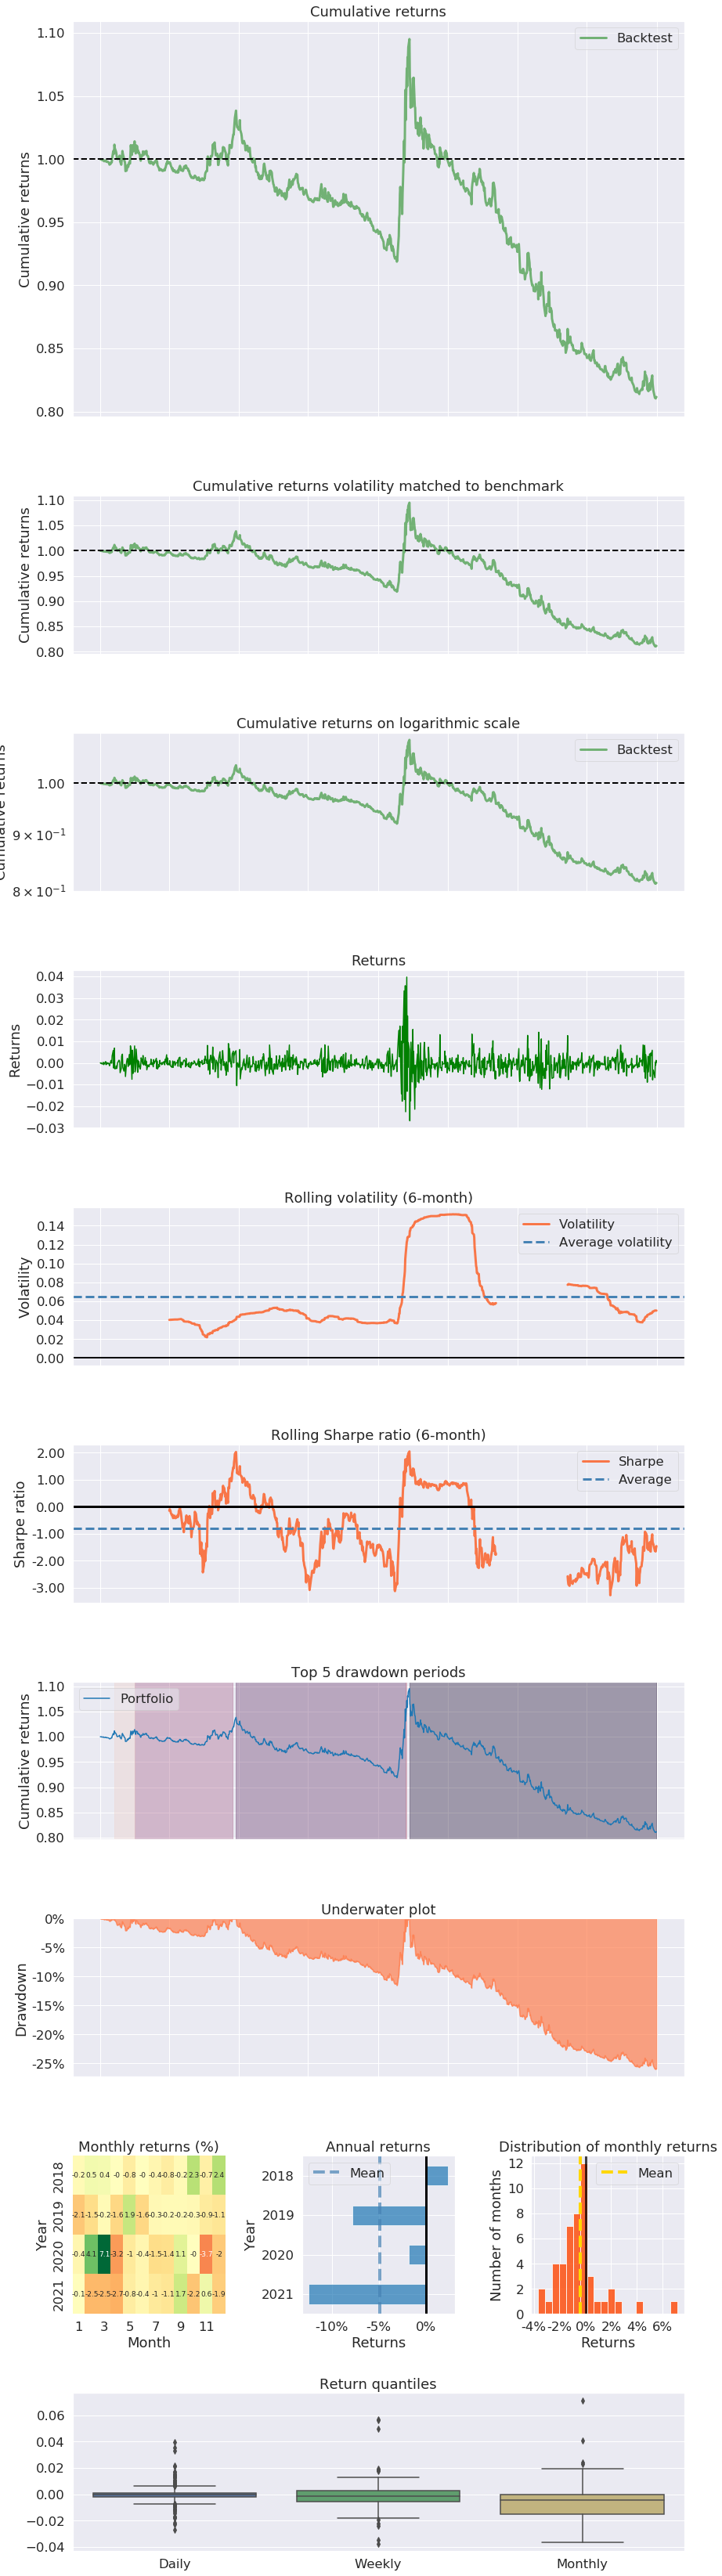

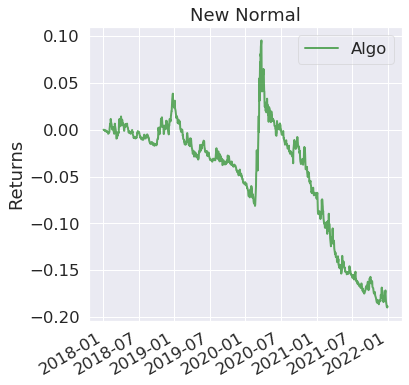

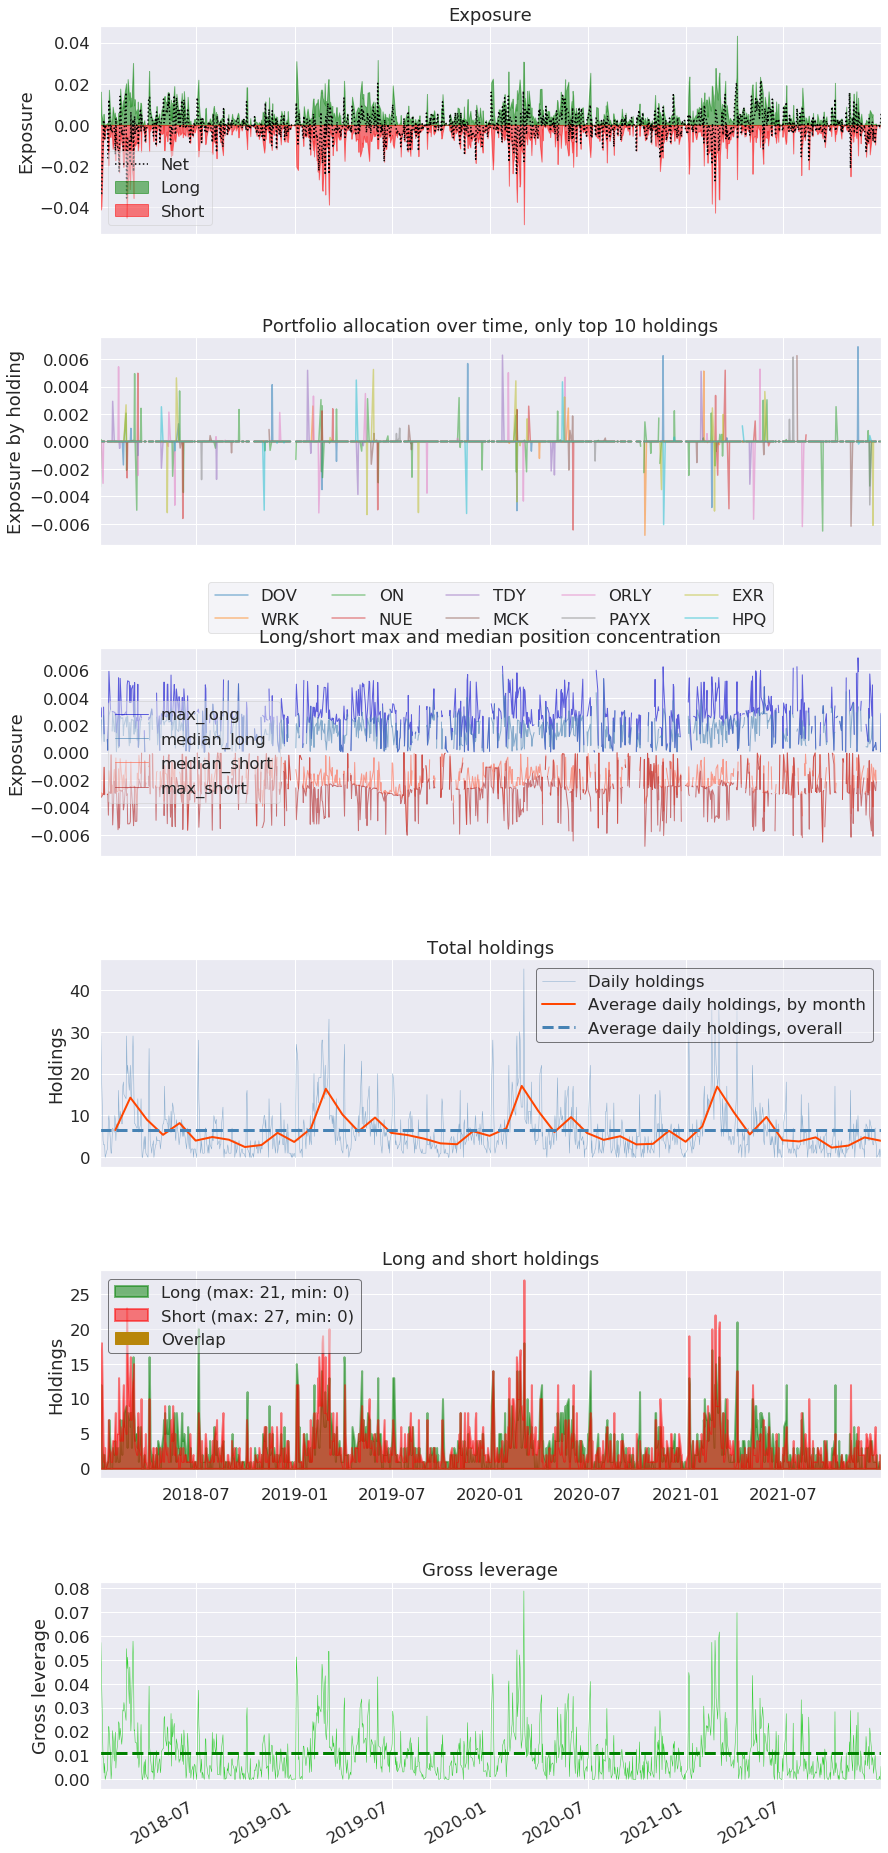

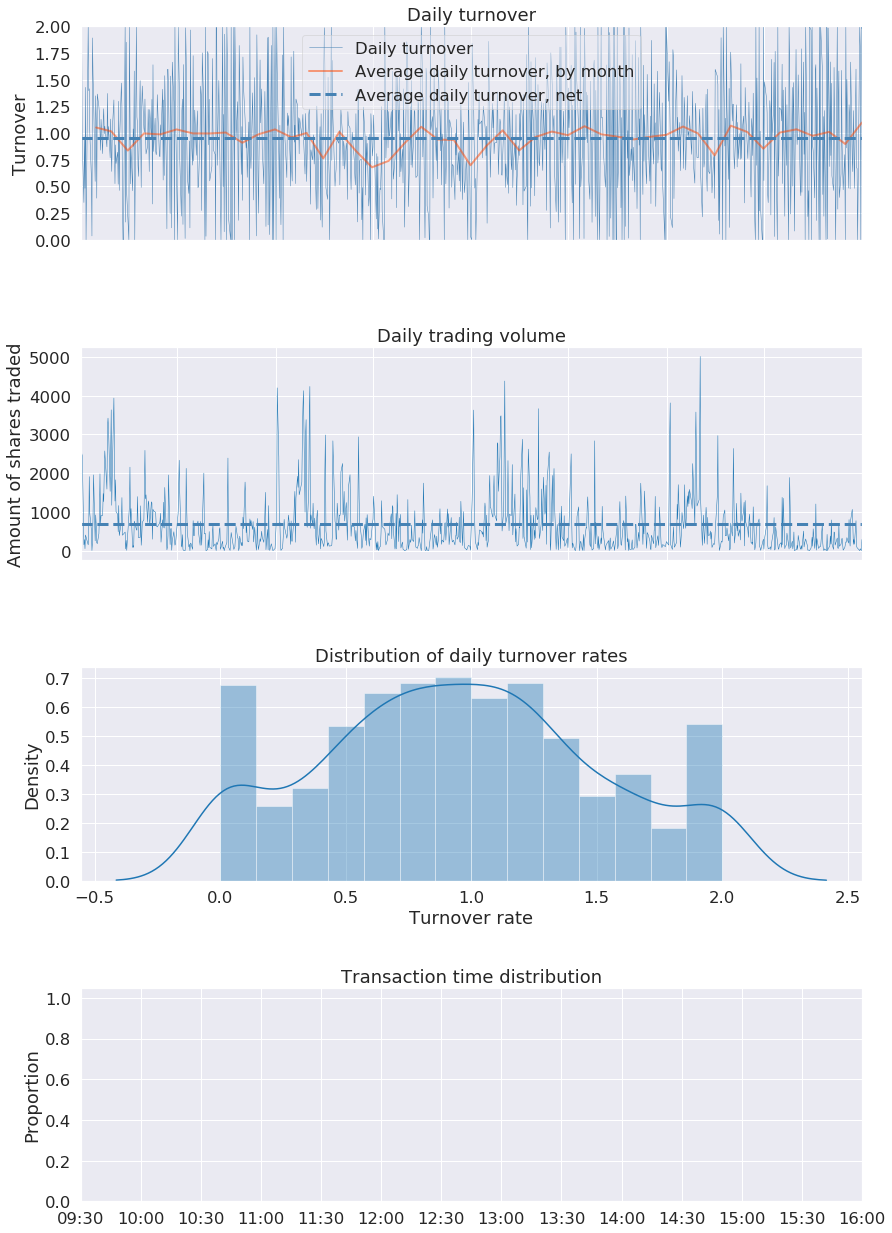

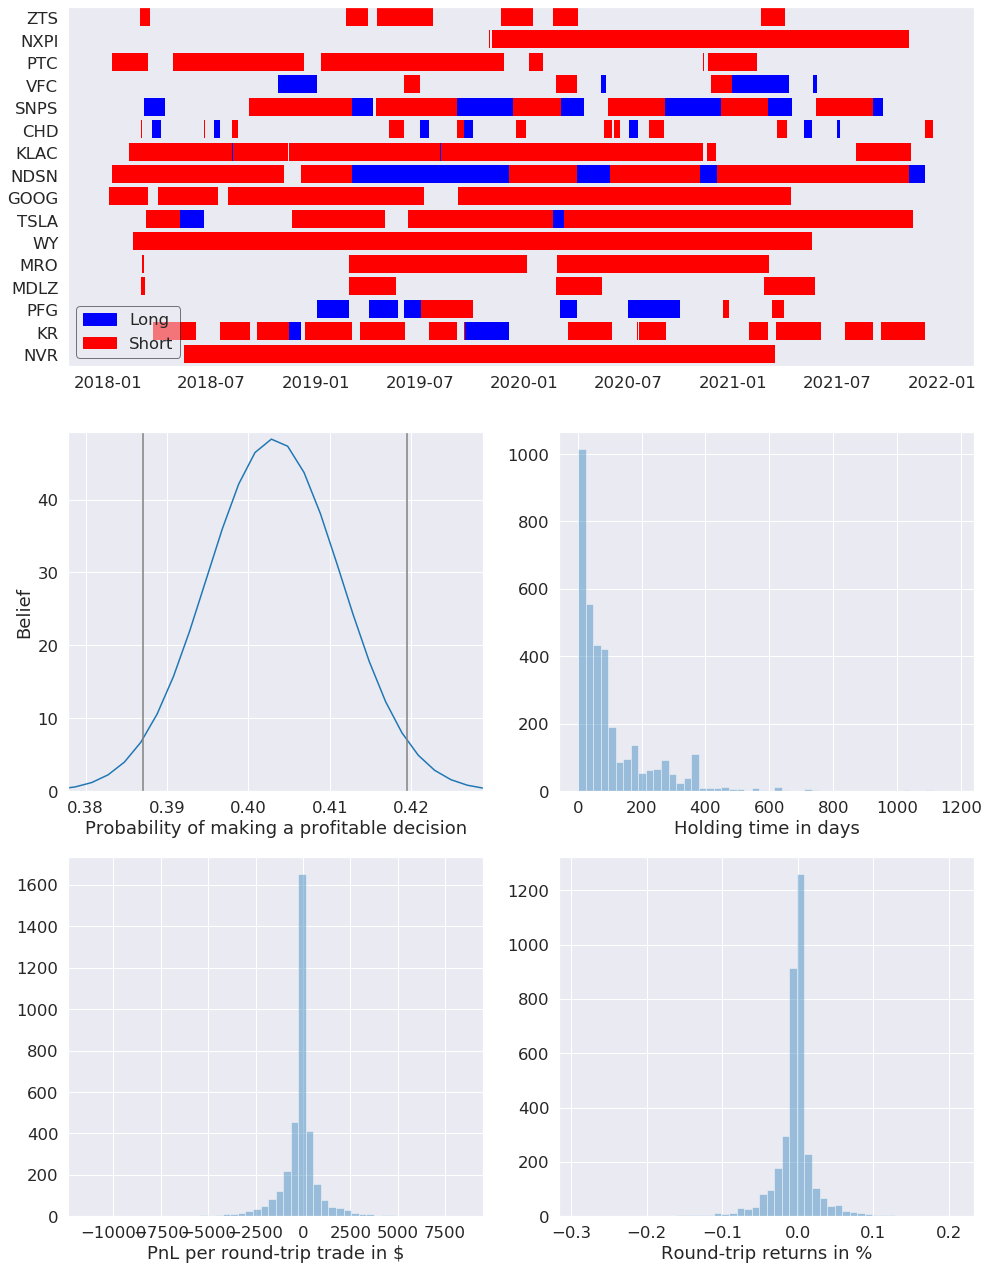

In [8]:
%matplotlib inline
import pyfolio as pf
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2005-05-01',  # This date is sample specific
    round_trips=True)